<div>
<h1>HS 4114 Course Project: Analysing Rap Vocals</h1> 
</div>



<br/>

<p>

</p> 

## Section 1: tempogram stuff
This section contains code for generating tempograms for the rap vocals

In [1]:
import os, sys
import numpy as np
import librosa
from scipy import signal
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import IPython.display as ipd
from numba import jit
import soundfile
import warnings
warnings.filterwarnings('ignore')

sys.path.append('..')
import libfmp.b
import libfmp.c2
import libfmp.c3
import libfmp.c6

%matplotlib inline


@jit(nopython=True)
def compute_tempogram_fourier(x, Fs, N, H, Theta=np.arange(30, 601, 1)):
    """Compute Fourier-based tempogram [FMP, Section 6.2.2]

    Notebook: C6/C6S2_TempogramFourier.ipynb

    Args:
        x (np.ndarray): Input signal
        Fs (scalar): Sampling rate
        N (int): Window length
        H (int): Hop size
        Theta (np.ndarray): Set of tempi (given in BPM) (Default value = np.arange(30, 601, 1))

    Returns:
        X (np.ndarray): Tempogram
        T_coef (np.ndarray): Time axis (seconds)
        F_coef_BPM (np.ndarray): Tempo axis (BPM)
    """
    win = np.hanning(N)
    N_left = N // 2
    L = x.shape[0]
    L_left = N_left
    L_right = N_left
    L_pad = L + L_left + L_right
    # x_pad = np.pad(x, (L_left, L_right), 'constant')  # doesn't work with jit
    x_pad = np.concatenate((np.zeros(L_left), x, np.zeros(L_right)))
    t_pad = np.arange(L_pad)
    M = int(np.floor(L_pad - N) / H) + 1
    K = len(Theta)
    X = np.zeros((K, M), dtype=np.complex_)

    for k in range(K):
        omega = (Theta[k] / 60) / Fs
        exponential = np.exp(-2 * np.pi * 1j * omega * t_pad)
        x_exp = x_pad * exponential
        for n in range(M):
            t_0 = n * H
            t_1 = t_0 + N
            X[k, n] = np.sum(win * x_exp[t_0:t_1])
        T_coef = np.arange(M) * H / Fs
        F_coef_BPM = Theta
    return X, T_coef, F_coef_BPM



In [2]:
from ipywidgets import interact, fixed, FloatSlider, Select

def plot_novelty_fn_and_tempogram(x, Fs, filename):
    """
    start_time = start time for analysis in seconds
    dur = duration for analysis in seconds
    """
    nov, Fs_nov = libfmp.c6.compute_novelty_spectrum(x, Fs=Fs, N=2048, H=512, gamma=100, M=10, norm=True)
    nov, Fs_nov = libfmp.c6.resample_signal(nov, Fs_in=Fs_nov, Fs_out=100)

    N = 500 #corresponding to 5 seconds (Fs_nov = 100)
    H = 10
    Theta = np.arange(30, 601)
    X, T_coef, F_coef_BPM = compute_tempogram_fourier(nov, Fs_nov, N=N, H=H, Theta=Theta)
    tempogram = np.abs(X)

    fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.02], 
                                              'height_ratios': [1, 2]}, figsize=(8,5))        
    libfmp.b.plot_signal(nov, Fs_nov, ax=ax[0,0], color='k', title='Novelty function of ' + filename)
    ax[0,1].set_axis_off()
    libfmp.b.plot_matrix(tempogram, T_coef=T_coef, F_coef=F_coef_BPM, ax=[ax[1,0], ax[1,1]], 
                         title='Fourier tempogram of '+filename, ylabel='Tempo (BPM)', colorbar=True);
    plt.tight_layout()

In [3]:
def save_tempogram_spec(x, Fs, filename):
    plot_novelty_fn_and_tempogram(x, Fs, filename)
    plt.savefig('./output/images/tempograms/'+filename+'.png')

In [4]:
songs = ["candyshop", "bigpoppa", "mynameis", "stilldre", "whatsmyname"]
songs_with_bg = [songs[i] + ".mp3" for i in range(len(songs))]
songs_acapella = [songs[i] + "_acapella.mp3" for i in range(len(songs))]
clips_start_1 = [14, 22, 23, 18, 24]
clips_start_2 = [103, 136, 69, 120, 124]

In [ ]:
for i_song, song in enumerate(songs):
    fn_wav_bg = os.path.join('.', 'music', songs_with_bg[i_song])
    x_bg_1, Fs = librosa.load(fn_wav_bg, offset= clips_start_1[i_song], duration=10)
    fn_wav_acapella = os.path.join('.', 'music', songs_acapella[i_song])
    x_acapella_1, Fs = librosa.load(fn_wav_acapella, offset= clips_start_1[i_song], duration=10)
    x_bg_2, Fs = librosa.load(fn_wav_bg, offset= clips_start_2[i_song], duration=10)
    x_acapella_2, Fs = librosa.load(fn_wav_acapella, offset= clips_start_2[i_song], duration=10)
    save_tempogram_spec(x_bg_1, Fs, song+"_bg_1")
    soundfile.write("./output/audio/"+song+"_bg_1.wav", x_bg_1, Fs)
    save_tempogram_spec(x_bg_2, Fs, song+"_bg_2")
    soundfile.write("./output/audio/"+song+"_bg_2.wav", x_bg_2, Fs)
    save_tempogram_spec(x_acapella_1, Fs, song+"_acapella_1")
    soundfile.write("./output/audio/"+song+"_acapella_1.wav", x_acapella_1, Fs)
    save_tempogram_spec(x_acapella_2, Fs, song+"_acapella_2")
    soundfile.write("./output/audio/"+song+"_acapella_2.wav", x_acapella_2, Fs)
    print(song+ " done")

## Section 2: Chromagram stuff
This section contains code to produce chromagrams for the song excerpts

In [38]:
import libfmp.c3
eps = np.finfo(float).eps
def plot_lf_spectrogram_and_chromagram(x, Fs, filename):
    N, H = 4096, 512
    X, T_coef, F_coef = libfmp.c2.stft_convention_fmp(x, Fs, N, H)
    Y = np.abs(X) ** 2
    Y_LF, F_coef_pitch = libfmp.c3.compute_spec_log_freq(Y, Fs, N)
    C = libfmp.c3.compute_chromagram(Y_LF)

    fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.02], 
                                              'height_ratios': [3, 2]}, figsize=(8, 5))  

    libfmp.b.plot_matrix(10 * np.log10(eps + Y_LF), Fs=Fs/H, ax=[ax[0,0], ax[0,1]], 
            ylim=[55,92], clim=[0, 50], title='Log-frequency spectrogram of '+filename, 
            ylabel='Frequency (pitch)', colorbar=True, cbar_label='Magnitude (dB)');

    libfmp.b.plot_chromagram(10 * np.log10(eps + C), Fs=Fs/H, ax=[ax[1,0], ax[1,1]],  
            chroma_yticks = [0,4,7,11], clim=[10, 50], title='Chromagram of ' + filename, 
            ylabel='Chroma', colorbar=True, cbar_label='Magnitude (dB)');

    plt.tight_layout()
    
def compute_pcd(x, Fs):
    N, H = 4096, 512
    X, T_coef, F_coef = libfmp.c2.stft_convention_fmp(x, Fs, N, H)
    Y = np.abs(X) ** 2
    Y_LF, F_coef_pitch = libfmp.c3.compute_spec_log_freq(Y, Fs, N)
    C = libfmp.c3.compute_chromagram(Y_LF)
    PCD = np.mean(C, axis=1)
    PCD = PCD/sum(PCD)
    return PCD

In [8]:
def save_chromagram_spec(x, Fs, filename):
    plot_lf_spectrogram_and_chromagram(x, Fs, filename)
    plt.savefig('./output/images/chromagrams/'+filename+'.png')

In [ ]:
for i_song, song in enumerate(songs):
    fn_wav_acapella = os.path.join('.', 'music', songs_acapella[i_song])
    x_acapella_1, Fs = librosa.load(fn_wav_acapella, offset= clips_start_1[i_song], duration=10)
    x_acapella_2, Fs = librosa.load(fn_wav_acapella, offset= clips_start_2[i_song], duration=10)
    save_chromagram_spec(x_acapella_1, Fs, song+"_acapella_1")
    save_chromagram_spec(x_acapella_2, Fs, song+"_acapella_2")
    print(song+ " done")

In [39]:
PCDs = np.zeros((len(songs)*2, 12))
for i_song, song in enumerate(songs):
    fn_wav_acapella = os.path.join('.', 'music', songs_acapella[i_song])
    x_acapella_1, Fs = librosa.load(fn_wav_acapella, offset= clips_start_1[i_song], duration=10)
    x_acapella_2, Fs = librosa.load(fn_wav_acapella, offset= clips_start_2[i_song], duration=10)
    PCDs[2*i_song,:] = compute_pcd(x_acapella_1, Fs)
    PCDs[2*i_song+1, :] = compute_pcd(x_acapella_2, Fs)

In [53]:
PCDs_speech = np.zeros((2, 12))
x_speech_1, Fs = librosa.load("./music/speech.m4a", offset=50, duration=10)
x_speech_2, Fs = librosa.load("./music/speech.m4a", offset=140, duration=10)

PCD_speech = np.zeros(12)
PCDs_speech[0] = compute_pcd(x_speech_1, Fs)
PCDs_speech[1] = compute_pcd(x_speech_2, Fs)
PCD_speech = (PCD_speech[0] + PCD_speech[1])/2

x_pop_1, Fs = librosa.load("./music/herecomesthesunacapella.mp3", duration=10)
x_pop_2, Fs = librosa.load("./music/herecomesthesunacapella.mp3", offset =34, duration=10)

PCD_pop = np.zeros(12)
PCDs_pop_1 = compute_pcd(x_pop_1, Fs)
PCDs_pop_2 = compute_pcd(x_pop_2, Fs)
PCD_pop = (PCDs_pop_1 + PCDs_pop_2)/2

In [49]:
soundfile.write("./output/audio/speech_1.wav", x_speech_1, Fs)
soundfile.write("./output/audio/speech_2.wav", x_speech_2, Fs)
soundfile.write("./output/audio/pop_1.wav", x_pop_1, Fs)
soundfile.write("./output/audio/pop_2.wav", x_pop_2, Fs)

In [ ]:
save_chromagram_spec(x_speech_1, Fs, "speech_1")
save_chromagram_spec(x_speech_2, Fs, "speech_2")
save_chromagram_spec(x_pop_1, Fs, "pop_1")
save_chromagram_spec(x_pop_2, Fs, "pop_2")

In [ ]:
save_tempogram_spec(x_speech_1, Fs, "speech_1")
save_tempogram_spec(x_speech_2, Fs, "speech_2")
save_tempogram_spec(x_pop_1, Fs, "pop_1")
save_tempogram_spec(x_pop_2, Fs, "pop_2")

In [83]:
distances = np.zeros((10, 2))
for i_PCD in range(len(PCDs)):
    distances[i_PCD, 0] = np.linalg.norm(PCDs[i_PCD, :] - np.mean(PCDs[i_PCD, :]) - (PCDs_speech[0]+PCDs_speech[1])/2 + np.mean((PCDs_speech[0]+PCDs_speech[1])/2))
    distances[i_PCD, 1] = np.linalg.norm(PCDs[i_PCD, :] - np.mean(PCDs[i_PCD, :]) - (PCDs_pop_1+PCDs_pop_2)/2 + np.mean((PCDs_pop_1+PCDs_pop_2)/2))

In [106]:
distances = np.zeros((10, 4))
for i_PCD in range(len(PCDs)):
    distances[i_PCD, 0] = np.linalg.norm(PCDs[i_PCD, :] - PCDs_speech[0])
    distances[i_PCD, 1] = np.linalg.norm(PCDs[i_PCD, :] - PCDs_speech[1])
    distances[i_PCD, 2] = np.linalg.norm(PCDs[i_PCD, :] - PCDs_pop_1)
    distances[i_PCD, 3] = np.linalg.norm(PCDs[i_PCD, :] - PCDs_pop_2)

Text(0, 0.5, '$l_2^2$ distance')

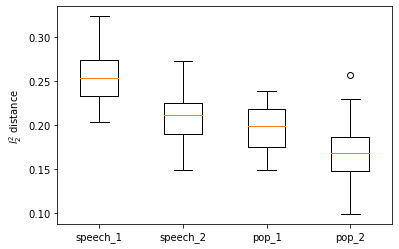

In [107]:
plt.boxplot(distances, labels=["speech_1", "speech_2", "pop_1", "pop_2"])
plt.ylabel("$l_2^2$ distance")

In [93]:
import scipy.stats

entropies = np.zeros((10))
for i_PCD in range(len(PCDs)):
    entropies[i_PCD] = scipy.stats.entropy(PCDs[i_PCD, :])

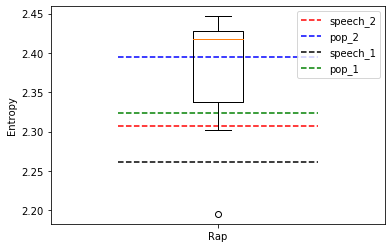

In [103]:
plt.boxplot(entropies, labels=["Rap"])
plt.ylabel("Entropy")
plt.hlines(scipy.stats.entropy((PCDs_speech[1])), 0.7, 1.3, label="speech_2", linestyle="dashed", colors= "red")
plt.hlines(scipy.stats.entropy((PCDs_pop_2)), 0.7, 1.3, linestyle="dashed", label="pop_2", colors = "blue")
plt.hlines(scipy.stats.entropy((PCDs_speech[0])), 0.7, 1.3, label="speech_1", linestyle="dashed", colors= "black")
plt.hlines(scipy.stats.entropy((PCDs_pop_1)), 0.7, 1.3, linestyle="dashed", label="pop_1", colors = "green")
plt.legend()